Using device: cuda
Loading data from ready_data_splits/val_split.csv...
Loading Model from resnet50_stanford_cars.pth...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16832\4036238744.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

Running Inference on 1219 images...

       TEST RESULTS       
Overall Accuracy: 79.98%

Generating Detailed Report...

--- Top 5 Best Classified Cars ---
    precision  recall  f1-score  support
39        1.0     1.0       1.0      6.0
51        1.0     1.0       1.0      6.0
46        1.0     1.0       1.0      5.0
59        1.0     1.0       1.0      5.0
67        1.0     1.0       1.0      6.0

--- Top 5 Worst Classified Cars ---
    precision    recall  f1-score  support
23   0.250000  0.142857  0.181818      7.0
63   0.250000  0.250000  0.250000      4.0
70   0.333333  0.200000  0.250000      5.0
22   0.333333  0.333333  0.333333      6.0
13   0.400000  0.285714  0.333333      7.0

Generating Confusion Matrix (First 20 classes)...


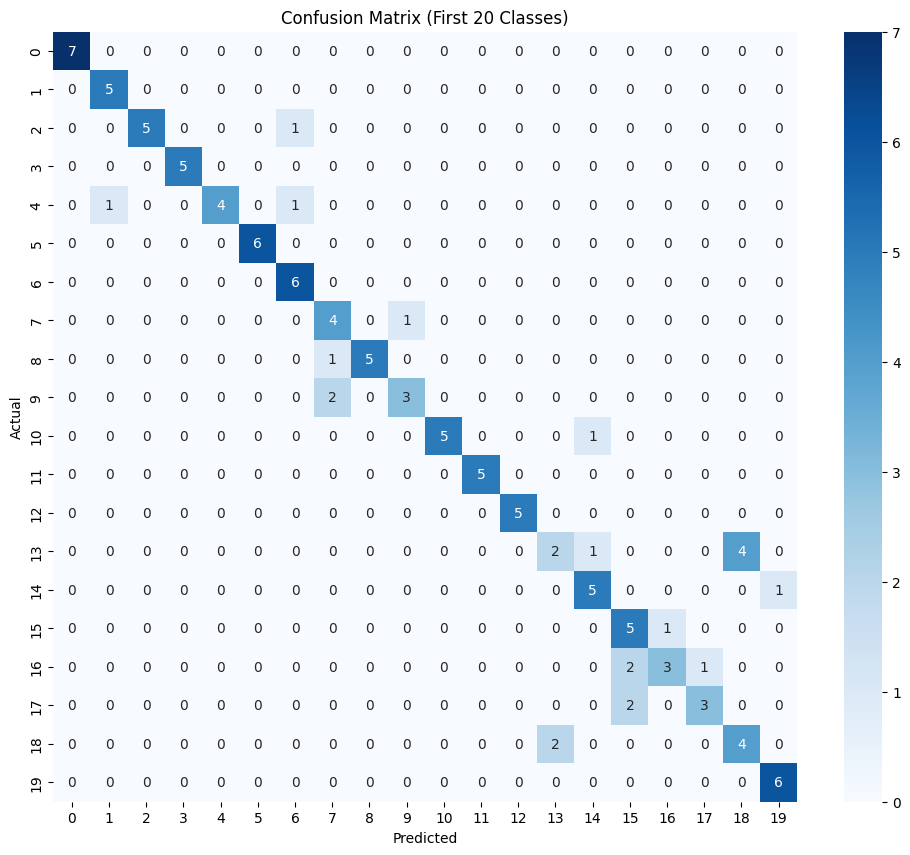


Calculating ROC & AUC...


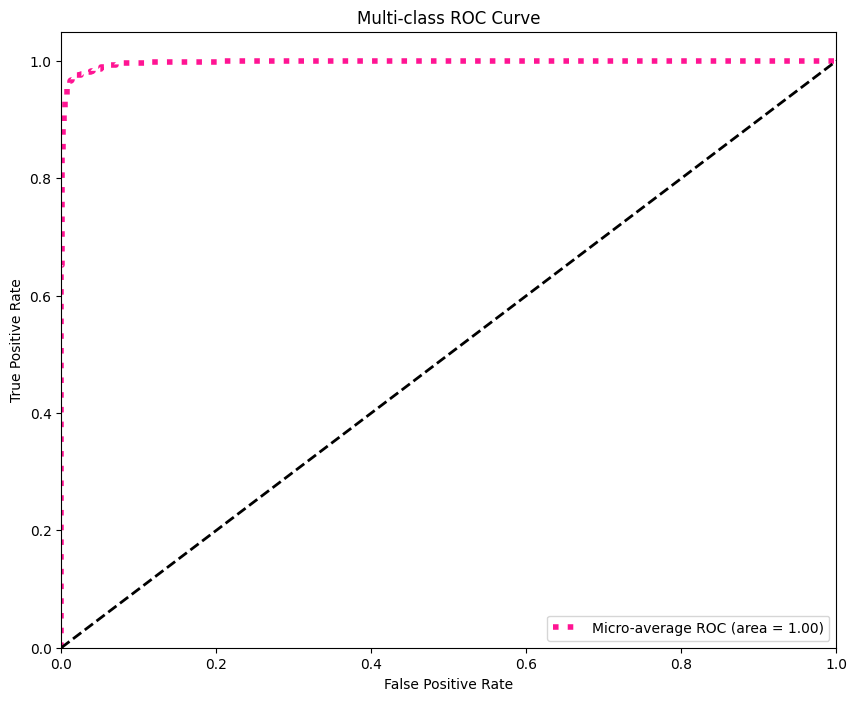

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from model_utils import UniversalCarDataset, get_transforms  # Import shared tools

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Point to the CSV split created by prepare_data.py
VAL_CSV = "ready_data_splits/val_split.csv"  # Validation Set
# Or use "ready_data_splits/test_split.csv" for final testing

MODEL_PATH = "resnet50_stanford_cars.pth"
BATCH_SIZE = 32
NUM_CLASSES = 196

# ==========================================
# 2. MODEL ARCHITECTURE
# ==========================================
def get_resnet_model(num_classes=196):
    model = models.resnet50(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, num_classes)
    )
    return model

# ==========================================
# 3. EVALUATION LOGIC
# ==========================================
def evaluate_model(model_path, csv_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Load Data using Universal Loader
    print(f"Loading data from {csv_path}...")
    if not os.path.exists(csv_path):
        print(f"Error: {csv_path} not found. Run prepare_data.py first.")
        return

    tfms = get_transforms(img_size=(224, 224))
    # Use 'val' transform (no augmentation, just resize/norm)
    dataset = UniversalCarDataset(csv_path, transform=tfms['val'])
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # 2. Load Model
    print(f"Loading Model from {model_path}...")
    model = get_resnet_model(num_classes=NUM_CLASSES)
    
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except Exception as e:
        print(f"Error loading model weights: {e}")
        return

    model.to(device)
    model.eval()

    # 3. Inference Loop
    print(f"Running Inference on {len(dataset)} images...")
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # 4. Metrics & Visualization
    print("\n" + "="*30)
    print("       TEST RESULTS       ")
    print("="*30)

    # --- Accuracy ---
    acc = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {acc*100:.2f}%")

    # --- Classification Report ---
    print("\nGenerating Detailed Report...")
    # zero_division=0 handles cases where a class might be missing in the split
    report_dict = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    
    print("\n--- Top 5 Best Classified Cars ---")
    print(report_df.sort_values(by='f1-score', ascending=False).head(5))

    print("\n--- Top 5 Worst Classified Cars ---")
    classes_only = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
    print(classes_only.sort_values(by='f1-score', ascending=True).head(5))

    # --- Confusion Matrix ---
    print("\nGenerating Confusion Matrix (First 20 classes)...")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (First 20 Classes)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # --- ROC & AUC (One-vs-Rest) ---
    print("\nCalculating ROC & AUC...")
    # Note: If a class is missing in the split, label_binarize handles it, 
    # but roc_curve might complain if y_true has no samples for that class.
    # We handle this by checking unique classes.
    unique_classes = np.unique(all_labels)
    y_test_bin = label_binarize(all_labels, classes=range(NUM_CLASSES))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calculate for all classes present
    for i in range(NUM_CLASSES):
        if i in unique_classes:
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        else:
            roc_auc[i] = 0.0 # No data for this class in this split

    # Compute micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == "__main__":
    if os.path.exists(MODEL_PATH):
        evaluate_model(MODEL_PATH, VAL_CSV)
    else:
        print(f"Error: Model {MODEL_PATH} not found.")